In [1]:
from src.time_series_prep import *
import pandas as pd
from models.shared_layer import *
from torchviz import make_dot
from torchsummary import summary
from src.data_preprocessing import *
from src.visualizations import *
from src.global_configs import *
from src.time_series_prep import *
import matplotlib.pyplot as plt
import logging

# Initialize logger
logging.basicConfig(
    filename='training.log',  # File where logs will be saved
    level=logging.INFO,  # Set logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    # filemode='w'  # Overwrite log file on each run
)
logger = logging.getLogger()


In [55]:
df = pd.read_csv("data\\ohio-data\\processed\\2018\\train\\563_training.csv")
timestamp_col = 'ts'
freq = '5T'
df
df[timestamp_col] = pd.to_datetime(df[timestamp_col].astype(str), format="%d-%m-%Y %H:%M:%S")
# df = df.resample('5T', 'mean')
# Set the timestamp column as index
# df.set_index(timestamp_col, inplace=True)
# 

In [29]:
df[df.value == 0]


,ts,value


In [58]:
import numpy as np
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

# Generate a synthetic dataset as the complete data matrix
np.random.seed(0)
X = np.random.rand(100, 10)  # 100 rows, 10 features

# Introduce missing values to create X_incomplete
missing_mask = np.random.rand(*X.shape) < 0.1  # 10% missing values
X_incomplete = X.copy()
X_incomplete[missing_mask] = np.nan

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)

# Matrix completion using convex optimization to find low-rank solution
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

# Instead of solving the nuclear norm objective directly, 
# induce sparsity using singular value thresholding
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

# Calculate mean squared error for the imputation methods above
nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear Norm Minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("KNN Imputation MSE: %f" % knn_mse)


Imputing row 1/100 with 3 missing, elapsed time: 0.007
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Nov 24 07:54:15 PM: Your problem has 1000 variables, 1000 constraints, and 0 parameters.
(CVXPY) Nov 24 07:54:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 24 07:54:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 24 07:54:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 24 07:54:15 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 

In [ ]:
from pykalman import KalmanFilter

def fill_nulls_kalman(series):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    series_filled = series.copy()
    data = series.dropna().values
    kf = kf.em(data, n_iter=10)
    filled, _ = kf.smooth(series.values.reshape(-1, 1))
    return pd.Series(filled.flatten(), index=series.index)

df['ts'] = fill_nulls_kalman(df['ts'])

In [46]:
def interpolate_small_gaps(df, column, max_gap=3):
    """
    Interpolates gaps in the specified column of the DataFrame
    if the number of consecutive NaNs is less than or equal to max_gap.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column name to process.
    max_gap (int): Maximum number of consecutive NaNs to interpolate.
    
    Returns:
    pd.DataFrame: DataFrame with small gaps interpolated.
    """
    data = df[column]
    is_nan = data.isna()
    
    # Identify gaps smaller than or equal to max_gap
    gap_sizes = is_nan.groupby((~is_nan).cumsum()).cumsum()
    to_interpolate = (is_nan & (gap_sizes <= max_gap))
    
    # Interpolate only the small gaps
    data[to_interpolate] = data.interpolate(method='linear', limit=max_gap).loc[to_interpolate]
    data.fillna(0, inplace=True)
    return df

In [26]:
interpolate_small_gaps(df, 'value')

C:\Users\menna\AppData\Local\Temp\ipykernel_18500\887903714.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_interpolate] = data.interpolate(method='linear', limit=max_gap).loc[to_interpolate]


,ts,value
0,2021-09-13 12:33:00,219
1,2021-09-13 12:38:00,229
2,2021-09-13 12:43:00,224
3,2021-09-13 12:48:00,221
4,2021-09-13 12:53:00,215
...,...,...
12119,2021-10-28 23:36:00,252
12120,2021-10-28 23:41:00,254
12121,2021-10-28 23:46:00,250
12122,2021-10-28 23:51:00,246


In [17]:
time_diffs = df["ts"].diff().dt.total_seconds()
expected_interval = pd.to_timedelta(freq).total_seconds()
gap_lengths = time_diffs[time_diffs > expected_interval]
gap_sizes = (gap_lengths / expected_interval).astype(int)
gap_count = gap_sizes.value_counts().sort_index()
gap_sizes

C:\Users\menna\AppData\Local\Temp\ipykernel_18500\1293395543.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  expected_interval = pd.to_timedelta(freq).total_seconds()


70         4
212        3
1645      37
2151       6
3313       6
3360      47
4355       6
4566       4
5078     289
5302      37
5875      33
5944       4
6503      27
6705     103
8431     177
10157    148
10591      4
11218      5
11254     41
11324      8
11588      2
Name: ts, dtype: int32

In [23]:
np.sort(gap_sizes.values)

array([  2,   3,   4,   4,   4,   4,   5,   6,   6,   6,   8,  27,  33,
        37,  37,  41,  47, 103, 148, 177, 289])

In [47]:
def fill_na(df, test):
    """
    Fills missing values in the DataFrame with 0.

    Parameters:
    df (pd.DataFrame): The DataFrame with potential missing values.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    if test:
        df.fillna(0, inplace=True)
    else:
        df = interpolate_small_gaps(df, 'value')
    return df

def preprocessing_df(df, timestamp_col, freq, agg_func, test):
    """
    Applies a series of preprocessing steps: converts timestamp to datetime, resamples the data, normalizes values, and fills missing values.

    Parameters:
    df (pd.DataFrame): The DataFrame to preprocess.
    timestamp_col (str): The name of the timestamp column.
    freq (str): The resampling frequency (e.g., '5T' for 5 minutes).
    agg_func (str): The aggregation function to apply during resampling ('mean', 'sum', 'median').

    Returns:
    pd.DataFrame: Preprocessed DataFrame.
    """
    df = timestamp_type(df, timestamp_col)
    df = resample_data(df, freq, agg_func)
    df, scaler= normalize_data(df)
    df = fill_na(df, test)
    # df = imputation(df)
    return df, scaler



In [50]:
df = pd.read_csv("data\\ohio-data\\processed\\2018\\train\\563_training.csv")

df_x = preprocessing_df(df, 'ts', '5T', 'mean', False)


d:\NISC\Glucose biomedical\shared layer project\src\data_preprocessing.py:57: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'mean': df.resample(freq).mean,
d:\NISC\Glucose biomedical\shared layer project\src\data_preprocessing.py:58: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'sum': df.resample(freq).sum,
d:\NISC\Glucose biomedical\shared layer project\src\data_preprocessing.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'median': df.resample(freq).median


In [51]:
len(df_x[0][df_x[0].values == 0])

914

In [ ]:

def process_all_csv_files(input_folder, output_folder, timestamp_col='ts', freq='5T', agg_func='mean'):
    """
    Processes all CSV files in the specified input folder, applies preprocessing, and saves the processed files to the output folder.

    Parameters:
    input_folder (str): The folder containing the CSV files to process.
    output_folder (str): The folder where processed CSV files will be saved.
    timestamp_col (str): The name of the column containing the timestamps. Default is 'ts'.
    freq (str): The resampling frequency. Default is '5T' (5 minutes).
    agg_func (str): The aggregation function to apply during resampling. Default is 'mean'.

    Returns:
    int: Status code, 1 for success.
    """
    try:
        if not os.path.exists(input_folder):
            raise FileNotFoundError(f"The folder {input_folder} does not exist.")
        
        if os.path.exists(output_folder):
            shutil.rmtree(output_folder)
            # raise FileNotFoundError(f"The folder {output_folder} already exists.")

        # Traverse through all folders and files in the input directory
        for top, _, files in os.walk(input_folder):
            if files:
                sub_path = os.path.relpath(top, input_folder)
                full_save_folder_path = os.path.join(output_folder, sub_path)
                logging.info(f"Processing folder {top}, saving to {full_save_folder_path}")

                # Create output directories if they don't exist
                os.makedirs(full_save_folder_path, exist_ok=True)

                csv_files = [file for file in os.listdir(top) if file.endswith(".csv")]
                if not csv_files:
                    logging.warning(f"No CSV files found in {top}.")
                    continue

                for file in csv_files:
                    file_path = os.path.join(top, file)
                    df = pd.read_csv(file_path)

                    # Skip empty CSV files
                    if df.empty:
                        logging.warning(f"The file {file} is empty and was skipped.")
                        continue
                    
                    logging.info(f"Processing file {file}...")

                    # Apply preprocessing
                    try:
                        if top[-4:] != 'test':
                            processed_df, scaler= preprocessing_df(df, timestamp_col=timestamp_col, freq=freq, agg_func=agg_func, test = False)
                        else:
                            processed_df, scaler= preprocessing_df(df, timestamp_col=timestamp_col, freq=freq, agg_func=agg_func, test = True)

                        # Save the processed DataFrame
                        output_file_path = os.path.join(full_save_folder_path, file)
                        processed_df.to_csv(output_file_path, index=True)  # Ensure index is saved
                        logging.info(f"Processed and saved {file} to {output_file_path}.")
                        
                    except Exception as e:
                        logging.error(f"Error processing file {file}: {e}")
        
        return scaler
    except Exception as e:
        logging.error(f"Error processing CSV files in {input_folder}: {e}")
        return 0
    

In [65]:
df = pd.read_csv("data\\ohio-data\\processed\\cleaned\\2018\\test\\559_testing.csv")
# df['value']
X, y = prepare_time_series_data(df, 'value', window_size, prediction_horizon)

In [69]:
y

array([0.67916435, 0.82853963, 0.94803985, ..., 0.18622593, 0.15635088,
       0.11153829])

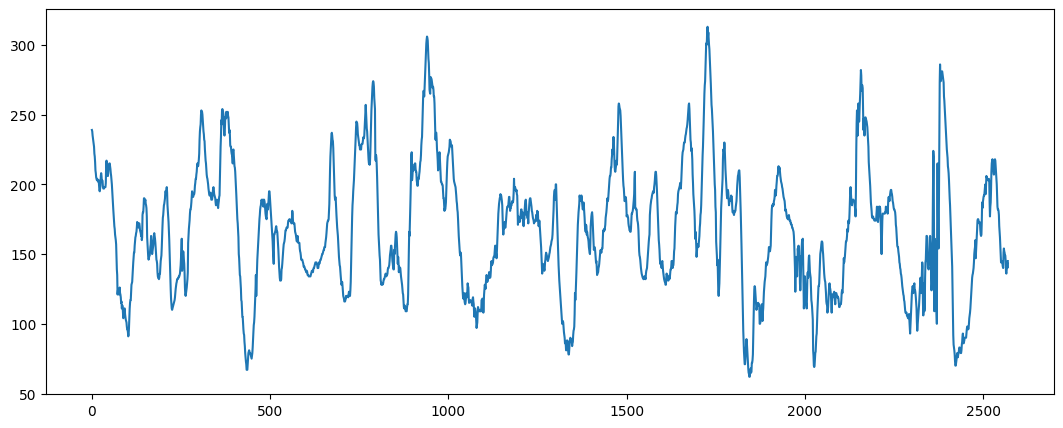

In [61]:
plt.figure(figsize=(13,5))
plt.plot(np.arange(len(df['value'])), df['value'])

In [2]:
scaler = process_all_csv_files(input_folder, output_folder_train, timestamp_col='ts', freq='5min', agg_func='mean')
_, _, _, test_loader, input_shape, input_shape_test, output_shape, output_shape_test =  prepare_data_loader(
                                                                                    window_size,BATCH_SIZE, prediction_horizon = 6,
                                                                                    model_type = 'shared-layer', split_ratio = 0.7, df = None, df_test = None, output_folder_train=output_folder_train, shuffle = False)


In [ ]:
model_all_train_read =  SharedLayerModelWithAttention(input_shape =input_shape , output_shape=output_shape)
model_all_train_read.load_state_dict(torch.load('saved_models\model_shared-layer_attention_6_0.pth'))
model_all_train_read.to(device)
model_all_train_read.eval()


C:\Users\menna\AppData\Local\Temp\ipykernel_6944\130584097.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_all_train_read.load_state_dict(torch.load('saved_models\

SharedLayerModelWithAttention(
  (pre_shared_personalized_tcn): ModuleList(
    (0-11): 12 x Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (downsample): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      )
    )
  )
  (pre_shared_personalized_gru): ModuleList(
    (0-11): 12 x GRU(64, 64, batch_first=True)
  )
  (task_specific_attention): ModuleList(
    (0-11): 12 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
 

In [39]:
def model_prediction(model,test_loader, device, model_type):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs_all_batches = []
        targets_all_batches = []

        for inputs, targets in test_loader:
            # Move data to device (GPU or CPU)
            if model_type == "personalized":
                inputs = [inp.to(device) for inp in inputs]

            elif model_type == "shared-layer" or model_type == "generalized":
                inputs = [inp for inp in inputs]
                inputs = torch.tensor(np.array(inputs)).to(device)

            targets = targets.to(device)
            outputs = model(inputs)
            targets_all_batches.append(targets)
            outputs_all_batches.append(outputs)
    return outputs_all_batches, targets_all_batches
                # print([[outputs[0]]])
                # # # Convert to numpy arrays for masking
                # outputs_np = outputs.cpu().numpy()
                # targets_np = targets.cpu().numpy()
                # abs_patients_errors =  []
                # squared_patients_errors = []
def evaluate_test(model,test_loader, device ,scaler, mask_value, model_type):
    outputs_all_batches, targets_all_batches = model_prediction(model,test_loader, device, model_type)

    if model_type == "personalized":
        abs_patients_errors =  []
        squared_patients_errors = []
        for one_batch in range(len(outputs_all_batches)):
            outputs_np = outputs_all_batches[one_batch].cpu().numpy()
            targets_np = targets_all_batches[one_batch].cpu().numpy()


            for j in range(len(targets_np)):
                    if targets_np[j] != mask_value:
                        sub_output = scaler.inverse_transform([outputs_np[j]])[0][0]
                        sub_target = scaler.inverse_transform([targets_np[j]])[0][0]
                        abs_patients_errors.append(abs(sub_output-sub_target))
                        squared_patients_errors.append((sub_output-sub_target) ** 2)
        mae = np.mean(abs_patients_errors)
        rmse = np.sqrt(np.mean(squared_patients_errors))
        return mae, rmse
    elif model_type == "shared-layer" or model_type == "generalized":
        abs_patients_errors =  {key: [] for key in range(12)}
        squared_patients_errors =  {key: [] for key in range(12)}
        for one_batch in range(len(outputs_all_batches)):
            outputs_np = outputs_all_batches[one_batch].cpu().numpy()
            targets_np = targets_all_batches[one_batch].cpu().numpy()
            for i in range(len(targets_np)): #this prints a list of 12 values of each patient
                for j in range(len(targets_np[i])):
                    if targets_np[i][j] != mask_value:
                        sub_output = scaler.inverse_transform([[outputs_np[i][j]]])[0][0]
                        sub_target = scaler.inverse_transform([[targets_np[i][j]]])[0][0]
                        # print(sub_output)
                        # print(sub_target)
                        abs_patients_errors[j].append(abs(sub_output-sub_target))
                        squared_patients_errors[j].append((sub_output-sub_target) ** 2)
                        # print(abs_patients_errors)
        for patient in range(len(squared_patients_errors)):
            abs_patients_errors[patient] = np.mean(abs_patients_errors[patient])
            squared_patients_errors[patient] = np.sqrt(np.mean(squared_patients_errors[patient]))
        return abs_patients_errors, squared_patients_errors


In [6]:
mae, rmse=  evaluate_test(model_all_train_read,test_loader, device ,scaler, mask_value, 'shared-layer')

In [9]:
outputs_all_batches, targets_all_batches = model_prediction(model_all_train_read,test_loader, device, 'shared-layer')

In [21]:
outputs = torch.cat(outputs_all_batches, dim=0).cpu()
targets = torch.cat(targets_all_batches, dim=0).cpu()

In [22]:
targets

tensor([[1.1304, 0.7850, 0.2653,  ..., 0.9651, 1.8492, 0.4509],
        [1.1501, 0.8019, 0.2528,  ..., 0.8860, 1.8758, 0.4509],
        [1.1697, 0.8019, 0.2275,  ..., 0.8044, 1.9110, 0.4509],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [23]:

# targets = [[None if val1 == -2.5 else val1 for val1 in sublist1] for sublist1 in targets]
# outputs = [[None if val1 == -2.5 else val2 for val1, val2 in zip(sublist1, sublist2)]
#                  for sublist1, sublist2 in zip(outputs, targets)]

# Create a mask where arr1 equals 0
mask = (targets == 0)

# Set elements to None (or np.nan for float compatibility)
targets = np.where(mask, None, targets)
outputs = np.where(mask, None, outputs)


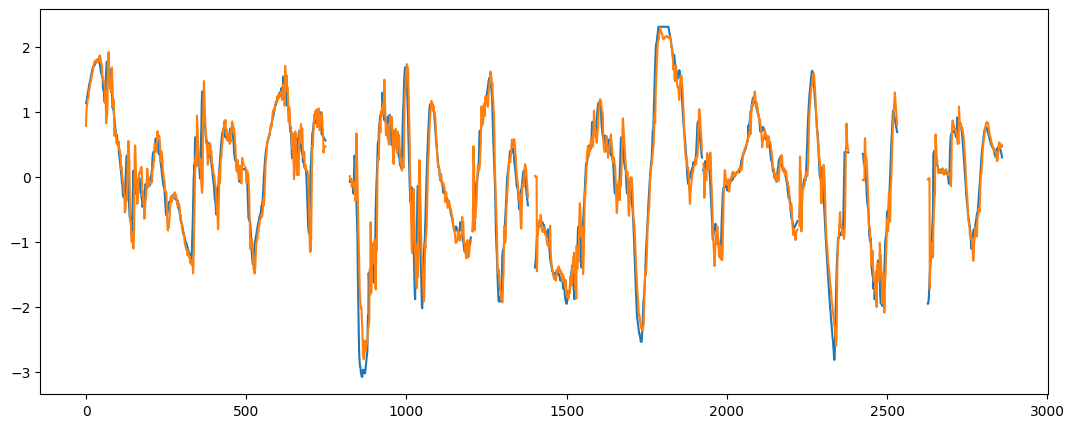

In [24]:
index = 0
patient1_target = [sublist[index] for sublist in targets]
patient1_output = [ sublist[index]  for sublist in outputs]
plt.figure(figsize=(13,5))
plt.plot(patient1_target)
plt.plot(patient1_output)